# How Anxcor uses XArray to simplify timeseries operations. 
## Part I. Obspy Stream Conversion to XArray.DataArray

XArray's DataArray and DataSet objects are meant to provide pandas DataFrame-like access to nd array labeled tensors. These notebook examples illustrates their basic functionality by looking at how Anxcor converts obspy streams to DataArrays, and applies signal processing routines to them.

The actual execution of these steps is handled automatically by Anxcor. You can, of course, import and use Anxcor Processing functions as you wish, but its not strictly required.

Lets set up the matplotlib inline environmental variable and import the libraries required for this example.

In [2]:
from anxcor.xarray_routines import XArrayConverter
from obspy import read
import matplotlib.pyplot as plt
%matplotlib inline

Obspy's ```read()``` function yields an Earthquake waveform as seen on one station over three channels. The stream object is an iterable list of Obspy Trace's, which contain metadata associated with each waveform. 

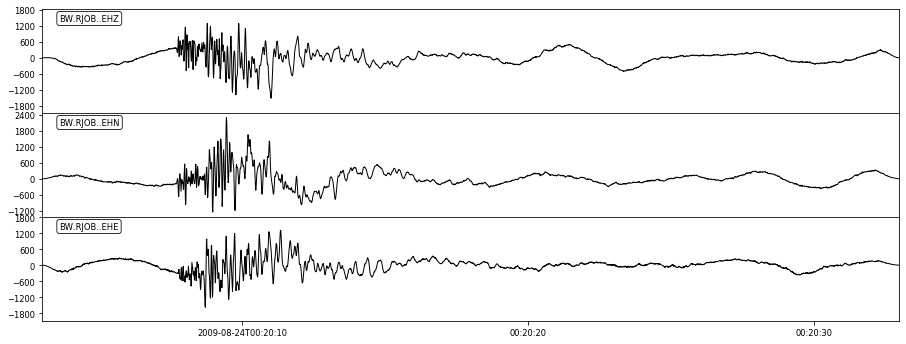

In [3]:
stream= read()
fig=plt.figure(figsize=(14,5))
stream.plot(fig=fig)
plt.show()

### Conversion Requirements

To better handle downstream signal processing, Anxcor can convert a stream object with any number of traces into an xarray DataArray with the XArrayConverter object. XArrayConverter uses the following assumptions when converting traces:
 * all traces have the same sampling rate
 * all traces have the same starttime
 * all traces have the **exact** same number of points/duration
 
It relies on the user to ensure this condition holds true. See the Anxcor_Data tutorials for more info

In [13]:
converter = XArrayConverter()
xarray    = converter(stream)
xarray

<xarray.DataArray 'my_assigned_data_type' (channel: 3, station_id: 1, time: 3000)>
array([[[ 0.      ,  0.006946, ...,  0.981962,  0.441969]],

       [[ 0.      ,  0.006044, ...,  0.492601,  0.254383]],

       [[ 0.      , -0.014434, ...,  0.435445,  0.197664]]])
Coordinates:
  * channel     (channel) <U3 'EHZ' 'EHN' 'EHE'
  * station_id  (station_id) <U7 'BW.RJOB'
  * time        (time) datetime64[ns] 2009-08-24T00:20:03 ... 2009-08-24T00:20:32.990000
Attributes:
    delta:       0.01
    starttime:   1251073203.0
    operations:  xconvert

### Metadata and Coordinates
The produced DataArray is 3 Dimensional, with dimensions(coordinates) of channel, station_id, and time. Note that Anxcor converts the network and station name into a single coordinate like so: 

"{network}.{station}". 

In this case, the station_id dimension has only one coordinate, "BW.RJOB". 

Anxcor only retains metadata needed for crosscorrelations, relying on the user to retain additional metadata. The metadata that is retained is contained in an ordered-dict property of the xarray

In [5]:
xarray.attrs

OrderedDict([('delta', 0.01),
             ('starttime', 1251073203.0),
             ('operations', 'xconvert')])

At this stage of processing, the xarray only contains the sampling interval as 'delta', the starttime as a UTCDateTime timestamp, and a string of data cataloging the applied operations to the data.
We've only converted the data to a DataArray, so the operations value only displays 'xconvert' for now.

DataArrays also have names which are accessible via the .name attribute. Anxcor uses this name attribute to further specify the *type* of seismic data contained by the DataArray. By default, all traces provided to anxcor are given the 'default' name attribute.

In [10]:
print('The name for this xarray is: \'{}\''.format(xarray.name))

The name for this xarray is: 'default'


to assign a specific name to the dataset, assign all traces in the delivered stream a data_type attribute by attaching it to the trace.stats object

In [12]:
stream= read()
for trace in stream:
    trace.stats.data_type='my_assigned_data_type'
named_xarray = converter(stream,starttime=0,station=0)
print('The name for this xarray is: \'{}\''.format(named_xarray.name))

The name for this xarray is: 'my_assigned_data_type'


### Plotting With XArray.DataArrays

DataArrays have built in plotting operations that work on 2D Arrays. Since our array is 3D, we need to first squeeze out the size 1 station_id dimension to plot. Note that this will not work on ND Arrays with no length=1 dimensions.

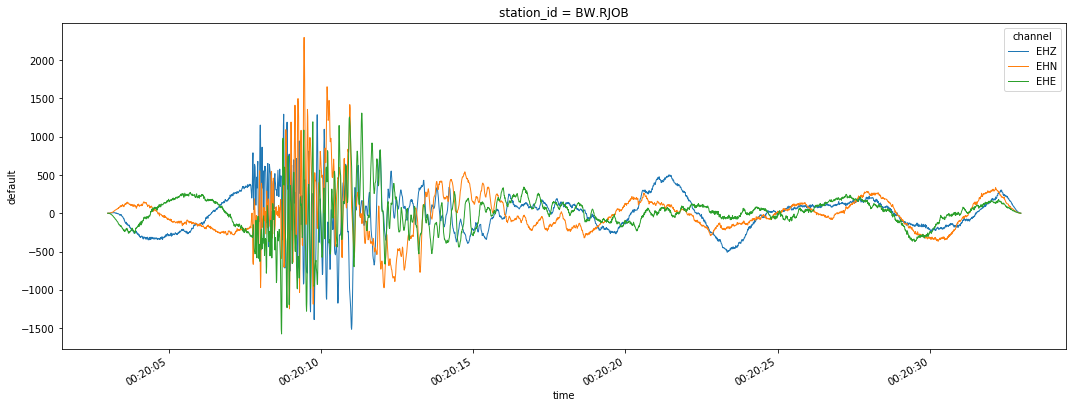

In [51]:
xarray_squeezed = xarray.squeeze()
xarray_squeezed.plot.line(x='time',aspect=3, size=6,linewidth=1)
plt.show()

In the next notebook, we'll look at Anxcor's basic signal processing routines

### References